<a href="https://colab.research.google.com/github/cris-her/AI/blob/master/dnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn #neural networks
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

# Construyendo un modelo

In [2]:
data_path = 'data/'

full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                                 transform = transforms.Compose(
                                    [transforms.ToTensor(),
                                    transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                         (0.2470, 0.2435, 0.2616))
                                  ]))





full_validation_set = datasets.CIFAR10(data_path, train=False, download=True, 
                                  transform = transforms.Compose(
                                  [transforms.ToTensor(),
                                  transforms.Normalize((0.4915, 0.4823, 0.4468), 
                                                       (0.2470, 0.2435, 0.2616))
                                ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Vamos a usar un dataloader para cargar los datos en un tamaño de batch especifico
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle = True, num_workers=2)

In [4]:
len(full_data_set)

50000

In [5]:
len(full_validation_set)

10000

Vamos a crear un iterador sobre  el data loader para obtener las imagenes y las etiquetas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog
truck
truck
ship


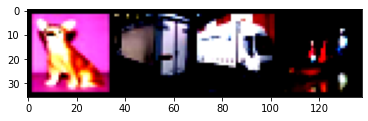

In [6]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2,0))

for i in range(size):
  print(classes[labels[i]])

De todo este dataset nos vamos a quedar unicamente con dos clases: car (posicion 1) y cat (posicion 3), y vamos a crear un nuevo dataset 

In [7]:
class_names = ['car', 'cat']

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1,3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1,3]]

In [8]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

Vamos a crear un modelo basado en una transformacion lineal de 32 x 32 x 3, ya que estamos intentando realizar una red neuronal, debemos utilizar una funcion de activacion, arbitrariamente usaremos una tangente hiperbolica **tanH**, pero haremos varias pruebas para ver que nos funciona mejor, luego de tanH vamos a tener una salida que necesitamos sea un resultado de un clasificador binario.

In [9]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2)
)

El resultado final debe ser una probabilidad, por lo que puedo trabajar con el sigmoide o con softmax (vemos ejemplo)

In [10]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

In [11]:
x = torch.tensor([1.0, 2.0, 3.0])

In [12]:
softmax(x).sum()
# La suma de cada evaluacion nos da 1

tensor(1.)

Agregamos al modelo la funcion softmax de pytorch

In [13]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1) # Usamos mas de una variable
)

Aplicamos el modelo a la imagen 20 del dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


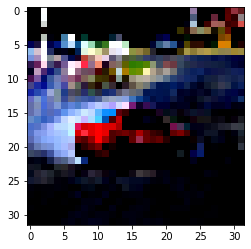

In [14]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [15]:
out =model(img.view(-1).unsqueeze(0))
out

tensor([[0.5701, 0.4299]], grad_fn=<SoftmaxBackward>)

Obtenemos la posicion del indice con torch.max() en el dataset para la prediccion

In [16]:
_, index = torch.max(out, dim=1) 
print('train dataset:', class_names[label], '| model:', class_names[index])

train dataset: car | model: car


# Implementando un clasificador totalmente conectado




En esta seccion vamos a cambiar Softmax por una funcion logaritmica dadas sus limitantes

In [17]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


this image is a car


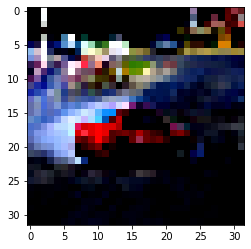

In [18]:
img, label = data_set[20]
plt.imshow(img.permute(1, 2, 0))
print(f'this image is a {class_names[label]}')

In [19]:
out = model(img.view(-1).unsqueeze(0))
print(out)

print('train dataset:', class_names[label], '| model:', class_names[index])

tensor([[-0.9022, -0.5203]], grad_fn=<LogSoftmaxBackward>)
train dataset: car | model: car


Creamos un loop de entrenamiento

In [20]:
model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 5 #iteraciones

for epoch in range(n_epochs):
  for img, label in data_set:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_function(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.06750672310590744
Eoch: 1, Loss: 0.043289344757795334
Eoch: 2, Loss: 0.015507824718952179
Eoch: 3, Loss: 0.028583675622940063
Eoch: 4, Loss: 1.6350032091140747


In [21]:
# Haciendo uno del train_loader
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512), 
    # dimension imagenes, numero de nodos de salidas de neuronas
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) # Usamos mas de una variable
)

loss_function = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.44655171036720276
Eoch: 1, Loss: 0.21530519425868988
Eoch: 2, Loss: 0.3623921871185303
Eoch: 3, Loss: 0.46866732835769653
Eoch: 4, Loss: 0.30053311586380005
Eoch: 5, Loss: 0.24547338485717773
Eoch: 6, Loss: 0.25847023725509644
Eoch: 7, Loss: 0.35348594188690186
Eoch: 8, Loss: 0.22430333495140076
Eoch: 9, Loss: 0.45388397574424744
Eoch: 10, Loss: 0.32295048236846924
Eoch: 11, Loss: 0.142139732837677
Eoch: 12, Loss: 0.14621201157569885
Eoch: 13, Loss: 0.1383470743894577
Eoch: 14, Loss: 0.38279733061790466
Eoch: 15, Loss: 0.34936150908470154
Eoch: 16, Loss: 0.08860237151384354
Eoch: 17, Loss: 0.11335628479719162
Eoch: 18, Loss: 0.09283791482448578
Eoch: 19, Loss: 0.15542766451835632
Eoch: 20, Loss: 0.3550383448600769
Eoch: 21, Loss: 0.22018121182918549
Eoch: 22, Loss: 0.20984025299549103
Eoch: 23, Loss: 0.09295820444822311
Eoch: 24, Loss: 0.08948875963687897
Eoch: 25, Loss: 0.33854734897613525
Eoch: 26, Loss: 0.13313758373260498
Eoch: 27, Loss: 0.12677577137947083
Eoch: 2

In [22]:
# Validamos el loss
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total))     

Accuracy: 0.864000


In [23]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
out

tensor([[-3.6955e-06, -1.2493e+01]], grad_fn=<LogSoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


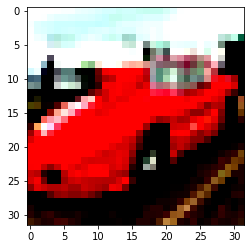

In [24]:
print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones

In [25]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024), #3072 = 3*32*32 
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),

)

#LogSoftmax tiene un efecto CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 100 #iteraciones

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Eoch: {epoch}, Loss: {float(loss)}")

Eoch: 0, Loss: 0.3990061283111572
Eoch: 1, Loss: 0.40964001417160034
Eoch: 2, Loss: 0.34644389152526855
Eoch: 3, Loss: 0.49685680866241455
Eoch: 4, Loss: 0.2760447859764099
Eoch: 5, Loss: 0.46100038290023804
Eoch: 6, Loss: 0.19625380635261536
Eoch: 7, Loss: 0.3115905523300171
Eoch: 8, Loss: 0.3731277287006378
Eoch: 9, Loss: 0.15172570943832397
Eoch: 10, Loss: 0.33926481008529663
Eoch: 11, Loss: 0.08962305635213852
Eoch: 12, Loss: 0.26877057552337646
Eoch: 13, Loss: 0.21506033837795258
Eoch: 14, Loss: 0.2925530970096588
Eoch: 15, Loss: 0.3265080451965332
Eoch: 16, Loss: 0.06549909710884094
Eoch: 17, Loss: 0.1620686948299408
Eoch: 18, Loss: 0.10301922261714935
Eoch: 19, Loss: 0.044864729046821594
Eoch: 20, Loss: 0.057774193584918976
Eoch: 21, Loss: 0.11112896353006363
Eoch: 22, Loss: 0.17947198450565338
Eoch: 23, Loss: 0.30100345611572266
Eoch: 24, Loss: 0.2832184433937073
Eoch: 25, Loss: 0.08003514260053635
Eoch: 26, Loss: 0.2981334626674652
Eoch: 27, Loss: 0.16270297765731812
Eoch: 28,

In [26]:
# Validamos el loss
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total)) 

Accuracy: 0.861000


In [27]:
# Validamos el loss
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())

print("Accuracy: %f"% (correct / total)) 

Accuracy: 1.000000


Nos encontramos con un modelo con overfiting sobre entrenado

In [28]:
### realizamos una suma de parametros (pesos)
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

El numero de parametros es muy grande para un dataset tan pequeño


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


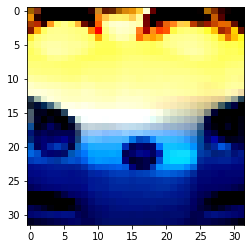

In [29]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))

Subir un grado de mejora seria trabajar con convulucion